In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import multiprocessing

# Disable CUDA because only one gpu device allows only a single chain
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax

jax.default_backend()
jax.devices()

2023-07-15 09:05:15.285548: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [3]:
from yomi_skill.model import YomiModel, weight_by
from yomi_skill.models import *
from yomi_skill.models.mu_glicko import *
from yomi_skill.yomi import historical_record
import pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tempfile

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, cross_validate

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
fit_dir = tempfile.mkdtemp()

In [5]:
tournament_games = historical_record.cached_tournament_games()
sirlin_games = historical_record.sirlin_db()
games = pandas.concat([tournament_games, sirlin_games]).reset_index(drop=True)

games

,match_date,player_1,character_1,win,character_2,player_2
0,2014-07-06 00:00:00,Jengajam,menelker,0,setsuki,fodazd
1,2014-07-06 00:00:00,MadKing,quince,1,setsuki,CKR
2,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing
3,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing
4,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing
...,...,...,...,...,...,...
120304,2015-09-07 19:11:01,DarkSephiroth,menelker,0,menelker,BONZAI
120305,2015-09-07 19:09:31,Kirandio,degrey,0,degrey,pfiidude
120306,2015-09-07 19:17:11,hartley,valerie,0,valerie,EricF
120307,2015-09-07 19:17:43,DarkSephiroth,menelker,0,menelker,BONZAI


In [6]:
games = historical_record.augment_dataset(games)

Constructing PC category
Estimating player glicko
Estimating player Elo
Estimating player-character glick
Estimating player-character Elo


In [7]:
weight_by(games, 'pc_elo')
weight_by(games, 'elo')

,match_date,player_1,character_1,win,character_2,player_2,player_character_1,player_character_2,elo_1,elo_2,...,pc_elo_diff_norm,pc_elo_max_norm_1,pc_elo_max_norm_2,pc_elo_weight,scaled_elo_1,scaled_elo_2,elo_diff_norm,elo_max_norm_1,elo_max_norm_2,elo_weight
25279,2013-06-15 21:53:19,Bob199,argagarg,1,argagarg,Hooves,Bob199-argagarg,Hooves-argagarg,1500.000000,1500.000000,...,1.140231,-0.113070,-0.101835,1.077080,-0.185717,-0.173770,1.228442,-0.185717,-0.173770,1.108535
25281,2013-06-16 01:10:29,Juushichi,gwen,0,gwen,Bob199,Juushichi-gwen,Bob199-gwen,1500.000000,1510.000000,...,1.140231,-0.113070,-0.101835,1.077080,-0.185717,0.036256,0.972662,-0.185717,0.036256,1.102820
25280,2013-06-16 01:12:44,Zigkirby,menelker,1,menelker,dereferenced,Zigkirby-menelker,dereferenced-menelker,1500.000000,1500.000000,...,1.140231,-0.113070,-0.101835,1.077080,-0.185717,-0.173770,1.228442,-0.185717,-0.173770,1.108535
25283,2013-06-16 01:20:01,Kiv,jaina,0,jaina,garcia1000,Kiv-jaina,garcia1000-jaina,1500.000000,1500.000000,...,1.140231,-0.113070,-0.101835,1.077080,-0.185717,-0.173770,1.228442,-0.185717,-0.173770,1.108535
25282,2013-06-16 01:20:25,Zigkirby,menelker,1,menelker,dereferenced,Zigkirby-menelker,dereferenced-menelker,1510.000000,1490.000000,...,0.545124,0.163109,-0.390715,1.026449,0.028440,-0.383796,0.740951,0.028440,-0.383796,1.048162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25275,2021-08-03 00:00:00,cpat,jaina,1,onimaru,mastrblastr,cpat-jaina,mastrblastr-onimaru,1820.011829,1687.953222,...,-0.725706,3.451814,5.164317,1.657275,6.667559,3.773738,-2.281238,6.667559,3.773738,2.019213
25278,2021-08-03 00:00:00,mastrblastr,degrey,1,zane,cpat,mastrblastr-degrey,cpat-zane,1687.953222,1820.011829,...,-3.914192,2.726971,7.346574,1.513076,3.839432,6.547314,-2.054792,3.839432,6.547314,2.040683
25273,2021-08-03 00:00:00,mastrblastr,onimaru,0,zane,cpat,mastrblastr-onimaru,cpat-zane,1687.953222,1820.011829,...,-1.507183,4.921561,7.346574,1.896391,3.839432,6.547314,-2.054792,3.839432,6.547314,2.040683
25274,2021-08-03 00:00:00,mastrblastr,degrey,0,zane,cpat,mastrblastr-degrey,cpat-zane,1687.953222,1820.011829,...,-3.914192,2.726971,7.346574,1.513076,3.839432,6.547314,-2.054792,3.839432,6.547314,2.040683


In [9]:
games[['player_character_1', 'player_character_2', 'elo_1', 'elo_2', 'scaled_elo_1', 'scaled_elo_2', 'elo_diff_norm', 'elo_max_norm_1', 'elo_max_norm_2', 'elo_weight']]

,player_character_1,player_character_2,elo_1,elo_2,scaled_elo_1,scaled_elo_2,elo_diff_norm,elo_max_norm_1,elo_max_norm_2,elo_weight
25279,Bob199-argagarg,Hooves-argagarg,1500.000000,1500.000000,-0.185717,-0.173770,1.228442,-0.185717,-0.173770,1.108535
25281,Juushichi-gwen,Bob199-gwen,1500.000000,1510.000000,-0.185717,0.036256,0.972662,-0.185717,0.036256,1.102820
25280,Zigkirby-menelker,dereferenced-menelker,1500.000000,1500.000000,-0.185717,-0.173770,1.228442,-0.185717,-0.173770,1.108535
25283,Kiv-jaina,garcia1000-jaina,1500.000000,1500.000000,-0.185717,-0.173770,1.228442,-0.185717,-0.173770,1.108535
25282,Zigkirby-menelker,dereferenced-menelker,1510.000000,1490.000000,0.028440,-0.383796,0.740951,0.028440,-0.383796,1.048162
...,...,...,...,...,...,...,...,...,...,...
25275,cpat-jaina,mastrblastr-onimaru,1820.011829,1687.953222,6.667559,3.773738,-2.281238,6.667559,3.773738,2.019213
25278,mastrblastr-degrey,cpat-zane,1687.953222,1820.011829,3.839432,6.547314,-2.054792,3.839432,6.547314,2.040683
25273,mastrblastr-onimaru,cpat-zane,1687.953222,1820.011829,3.839432,6.547314,-2.054792,3.839432,6.547314,2.040683
25274,mastrblastr-degrey,cpat-zane,1687.953222,1820.011829,3.839432,6.547314,-2.054792,3.839432,6.547314,2.040683


In [10]:
games[['player_character_1', 'player_character_2', 'pc_elo_1', 'pc_elo_2', 'scaled_pc_elo_1', 'scaled_pc_elo_2', 'pc_elo_diff_norm', 'pc_elo_max_norm_1', 'pc_elo_max_norm_2', 'pc_elo_weight']]

,player_character_1,player_character_2,pc_elo_1,pc_elo_2,scaled_pc_elo_1,scaled_pc_elo_2,pc_elo_diff_norm,pc_elo_max_norm_1,pc_elo_max_norm_2,pc_elo_weight
25279,Bob199-argagarg,Hooves-argagarg,1500.000000,1500.000000,-0.113070,-0.101835,1.140231,-0.113070,-0.101835,1.077080
25281,Juushichi-gwen,Bob199-gwen,1500.000000,1500.000000,-0.113070,-0.101835,1.140231,-0.113070,-0.101835,1.077080
25280,Zigkirby-menelker,dereferenced-menelker,1500.000000,1500.000000,-0.113070,-0.101835,1.140231,-0.113070,-0.101835,1.077080
25283,Kiv-jaina,garcia1000-jaina,1500.000000,1500.000000,-0.113070,-0.101835,1.140231,-0.113070,-0.101835,1.077080
25282,Zigkirby-menelker,dereferenced-menelker,1510.000000,1490.000000,0.163109,-0.390715,0.545124,0.163109,-0.390715,1.026449
...,...,...,...,...,...,...,...,...,...,...
25275,cpat-jaina,mastrblastr-onimaru,1629.078464,1682.295498,3.451814,5.164317,-0.725706,3.451814,5.164317,1.657275
25278,mastrblastr-degrey,cpat-zane,1602.833121,1757.837497,2.726971,7.346574,-3.914192,2.726971,7.346574,1.513076
25273,mastrblastr-onimaru,cpat-zane,1682.295498,1757.837497,4.921561,7.346574,-1.507183,4.921561,7.346574,1.896391
25274,mastrblastr-degrey,cpat-zane,1602.833121,1757.837497,2.726971,7.346574,-3.914192,2.726971,7.346574,1.513076


In [11]:
min_games = 0
warmup = 500
samples = 1000

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    games, games.win.astype('int'), random_state=42
)

In [17]:
MODELS = {
    model.model_name: model
    for model_type in YomiModel.__subclasses__()
    for model in model_type.__subclasses__()
}

In [18]:
MODELS

{'mu_pc_glicko': yomi_skill.models.mu_pc_glicko.MUPCGlicko,
 'pc_elo': yomi_skill.models.pc_elo.PCElo,
 'char_skill_skelo_skill_deficit': yomi_skill.models.char_skill_skelo_skill_deficit.CharSkillSkeloSkillDeficit,
 'mu': yomi_skill.models.mu_only.MUOnly,
 'glicko': yomi_skill.models.glicko.Glicko,
 'elo': yomi_skill.models.elo.Elo,
 'char_skill_glicko_skill_deficit': yomi_skill.models.char_skill_glicko_skill_deficit.CharSkillGlickoSkillDeficit,
 'mu_pc_elo': yomi_skill.models.mu_pc_elo.MUPCElo,
 'mu_elo': yomi_skill.models.mu_elo.MUElo,
 'mu_glicko': yomi_skill.models.mu_glicko.MUGlicko,
 'pc_glicko': yomi_skill.models.pc_glicko_only.PCGlicko}

In [19]:
model_names = ['mu', 'elo', 'mu_elo', 'pc_elo', 'mu_pc_elo', 'glicko', 'mu_glicko', 'pc_glicko', 'mu_pc_glicko']
models = {model_name: MODELS[model_name](fit_dir, min_games, warmup=warmup, samples=samples) for model_name in model_names}

In [20]:
df_pred_test = pandas.DataFrame(
    {
        model_name: models[model_name].fit(
            X_train,
            y_train,
            # sample_weight=X_train[f'{models[model_name].weight_key}_weight']
        ).predict_proba(X_test)[:, 1]
        for model_name in model_names
    }
)

Compiling...
Compilation time =  0:00:01.019252
Sampling...
Sampling time =  0:00:04.527777
Transforming variables...
Transformation time =  0:01:24.782220
Compiling...
Compilation time =  0:00:01.057215
Sampling...
Sampling time =  0:00:04.012032
Transforming variables...
Transformation time =  0:00:14.765181
Compiling...
Compilation time =  0:00:01.221586
Sampling...
Sampling time =  0:00:04.904695
Transforming variables...
Transformation time =  0:02:02.332966
Compiling...
Compilation time =  0:00:00.767359
Sampling...
Sampling time =  0:00:03.600120
Transforming variables...
Transformation time =  0:00:12.440736
Compiling...
Compilation time =  0:00:01.208939
Sampling...
Sampling time =  0:00:04.959653
Transforming variables...
Transformation time =  0:02:01.059476
Compiling...
Compilation time =  0:00:00.771015
Sampling...
Sampling time =  0:00:03.811146
Transforming variables...
Transformation time =  0:00:13.850650
Compiling...
Compilation time =  0:00:01.221748
Sampling...
Samp

In [21]:
df_pred_test.set_index(X_test.index)
pandas.concat([X_test, df_pred_test.set_index(X_test.index)], axis=1).sort_values('pc_elo_weight')[['player_1', 'character_1', 'win', 'character_2', 'player_2', 'pc_elo_1', 'pc_elo_2', 'pc_elo_weight'] + [model_name for model_name in model_names]]

,player_1,character_1,win,character_2,player_2,pc_elo_1,pc_elo_2,pc_elo_weight,mu,elo,mu_elo,pc_elo,mu_pc_elo,glicko,mu_glicko,pc_glicko,mu_pc_glicko
16870,MysticDeadman,gwen,1,setsuki,BD_Corro,1285.031673,1672.182716,0.000000,0.466996,0.440106,0.417609,0.440039,0.417119,0.486387,0.456119,0.492637,0.461325
16524,MysticDeadman,gwen,0,troq,shamusj,1288.746840,1501.167046,0.057754,0.320289,0.480260,0.310496,0.480238,0.311354,0.491134,0.315741,0.491273,0.315202
17248,Zejety,bbb,0,gwen,MysticDeadman,1532.733274,1328.820117,0.208125,0.446832,0.520277,0.463647,0.520300,0.464668,0.504311,0.449112,0.503768,0.448732
17219,Zejety,bbb,1,gwen,MysticDeadman,1532.733274,1328.820117,0.208125,0.446832,0.520277,0.463647,0.520300,0.464668,0.504311,0.449112,0.503768,0.448732
17220,CocktailsComic,argagarg,1,gwen,MysticDeadman,1518.327864,1328.820117,0.211333,0.564643,0.506953,0.566321,0.506961,0.565816,0.503870,0.566922,0.505205,0.568520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24671,deluks917,lum,0,onimaru,mastrblastr,1629.544295,1677.622725,1.660610,0.530344,0.494386,0.522602,0.494379,0.523579,0.499544,0.529441,0.499134,0.529427
13342,CloudCuckooCountry,geiger,1,setsuki,Fivec,1629.640113,1633.643091,1.671316,0.526540,0.479917,0.510600,0.479895,0.509489,0.494684,0.523234,0.499742,0.526064
24239,mi-go hunter,quince,1,zane,mastrblastr,1634.516079,1623.406698,1.671850,0.419581,0.498753,0.421148,0.498752,0.421769,0.499308,0.419886,0.500169,0.418862
18369,Fluffiness,persephone,1,troq,Caralad,1645.852919,1628.260763,1.693817,0.407978,0.484545,0.395164,0.484528,0.395503,0.496709,0.404552,0.500305,0.409341


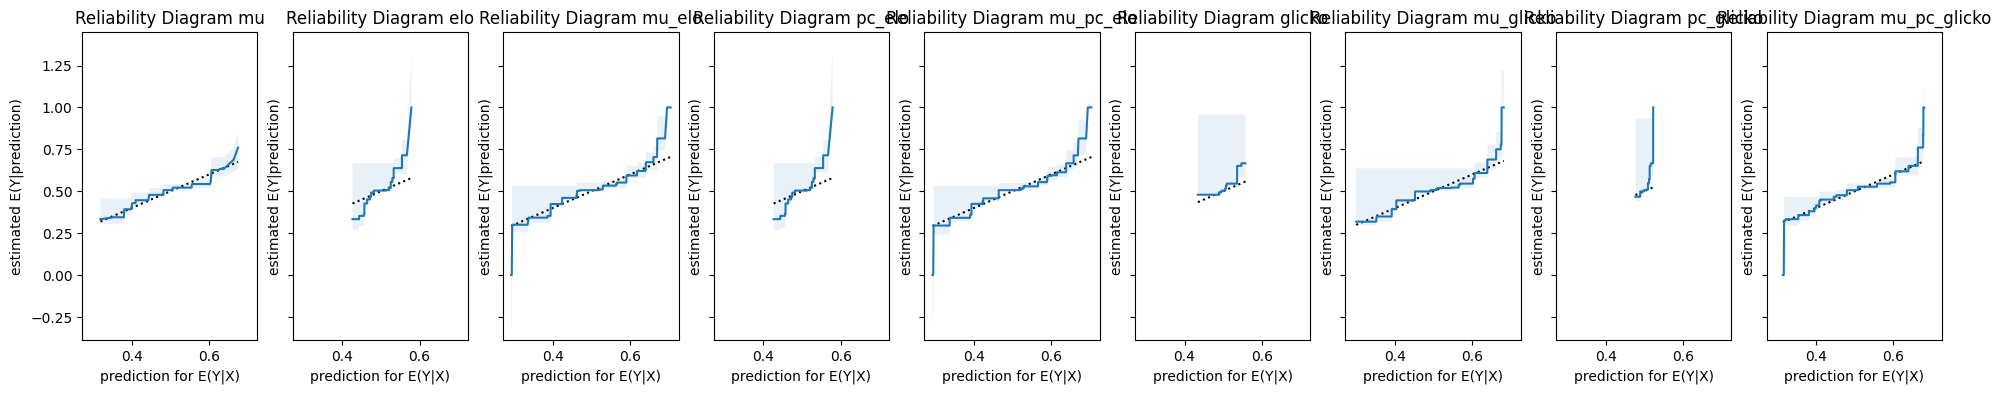

In [23]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias, plot_bias, plot_reliability_diagram
fig, axes = plt.subplots(ncols=len(model_names), figsize=(24, 4), sharex=True, sharey=True)

for i, model_name in enumerate(model_names):
    plot_reliability_diagram(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i],
    )

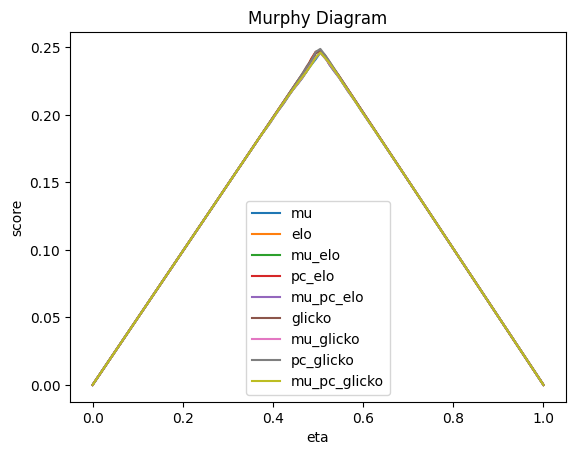

In [24]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram

ax = plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
)

In [26]:
from model_diagnostics.scoring import SquaredError, decompose
import polars as pl

df_list = []
for model_name in model_names:
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
    )
    df = df.with_columns(pl.lit(model_name).alias("model"))
    df_list.append(df)
pl.concat(df_list)[:, [-1, 0, 1, 2, 3]]


model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""mu""",0.000274,0.000858,0.249978,0.249394
"""elo""",0.000394,0.000451,0.249978,0.249921
"""mu_elo""",0.000538,0.001155,0.249978,0.249362
"""pc_elo""",0.000394,0.000451,0.249978,0.249921
"""mu_pc_elo""",0.000542,0.001158,0.249978,0.249362
"""glicko""",0.000163,0.00015,0.249978,0.24999
"""mu_glicko""",0.000411,0.000993,0.249978,0.249396
"""pc_glicko""",0.000125,0.000101,0.249978,0.250001
"""mu_pc_glicko""",0.00037,0.000947,0.249978,0.249401


In [18]:

clf_list = [
    (elo_only, "Elo Only"),
    (full, "Char Skill Elo Skill Deficit"),
]
test_subsets = [
    (True, False, "Low/Low"),
    (True, True, "Low/High"),
    (False, True, "High/High"),
]

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4*len(clf_list), 3)
colors = plt.get_cmap("Dark2")

calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    ax_calibration_curve = fig.add_subplot(gs[2*i:2*i+2, :3])
    for w, weighted in enumerate([True, False]):
        clf.fit(X_train, y_train, sample_weights=X_train.weight)
        for t, (low, high, lowhigh) in enumerate(test_subsets):
            label = f"{name} - {lowhigh} - weighted" if weighted else f"{name} - {lowhigh}"
            print(len(X_test[(X_test.has_low_skill == low) & (X_test.has_high_skill == high)]), len(y_test[(X_test.has_low_skill == low) & (X_test.has_high_skill == high)]))
            display = CalibrationDisplay.from_estimator(
                clf,
                X_test[(X_test.has_low_skill == low) & (X_test.has_high_skill == high)],
                y_test[(X_test.has_low_skill == low) & (X_test.has_high_skill == high)],
                n_bins=10,
                name=label,
                ax=ax_calibration_curve,
                color=colors(6*i + 2*w + t),
            )
            calibration_displays[label] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
for r, (_, name) in enumerate(clf_list):
    for w, weighted in enumerate([True, False]):
        row = 3+2*r+w
        for c, (low, high, lowhigh) in enumerate(test_subsets):
            label = f"{name} - {lowhigh} - weighted" if weighted else f"{name} - {lowhigh}"
            col = c
            ax = fig.add_subplot(gs[row, col])
        
            ax.hist(
                calibration_displays[label].y_prob,
                range=(0, 1),
                bins=10,
                label=label,
                color=colors(6*r + 2*w + c),
            )
            ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

Compiling...
Compilation time =  0:00:01.456196
Sampling...
Sampling time =  0:00:03.818383
Transforming variables...
Transformation time =  0:00:14.444868
25370 25370
5246 5246
452 452
Compiling...
Compilation time =  0:00:00.891735
Sampling...
Sampling time =  0:00:04.274907
Transforming variables...


In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss", 
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()